In [52]:
include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\2.1.MP-IS-MCQMC_M.jl");
# include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\test.jl");
# include(raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\2.1.HMC.JL");  

  Activating project at `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries`


MP_IS_MALA (generic function with 1 method)

In [ ]:
Theta_true = (1.5, 0.1,0.75,1); tspan = (5.0, 15.0); dt = 0.02;  
lok_volt = ODEProblem(lotka_volterra!, [5.0, 5.0], tspan, Theta_true); sol = solve(lok_volt, Tsit5(), saveat=dt);
lok_volt_2 = ODEProblem(lotka_volterra!, [10.0, 5.0], tspan, Theta_true); sol_2 = solve(lok_volt_2, Tsit5(), saveat=dt);
lok_volt_3 = ODEProblem(lotka_volterra!, [5.0, 10.0], tspan, Theta_true); sol_3 = solve(lok_volt_3, Tsit5(), saveat=dt);
lok_volt_4 = ODEProblem(lotka_volterra!, [7.5,7.5], tspan, Theta_true); sol_4 = solve(lok_volt_4, Tsit5(), saveat=dt);  
lok_volt_5 = ODEProblem(lotka_volterra!, [10.0, 10.0], tspan, Theta_true); sol_5 = solve(lok_volt_5, Tsit5(), saveat=dt);

plot(sol[1,:], sol[2,:], linewidth = 1.5, xlabel = "x", ylabel = "y", legend = false, 
     grid = true, gridalpha = 0.3, title = "True Orbit", fontsize =8, xlims=(0, 40))
plot!(sol_2[1,:], sol_2[2,:], linewidth = 1.5, color = "orange")
plot!(sol_3[1,:], sol_3[2,:], linewidth = 1.5, color = "green")
plot!(sol_4[1,:], sol_4[2,:], linewidth = 1.5, color = "purple")
plot!(sol_5[1,:], sol_5[2,:], linewidth = 1.5, color = "blue")

#### **Data Generation**

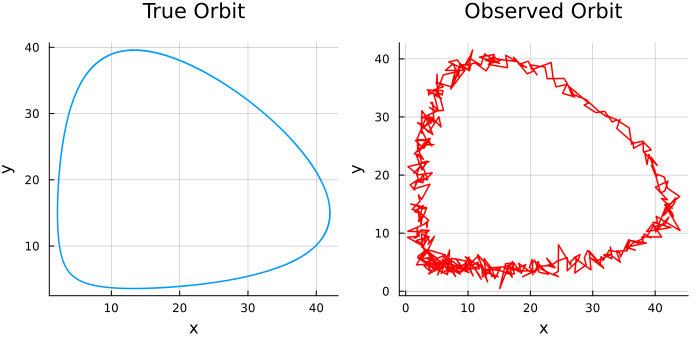

In [109]:
function lotka_volterra!(du, u, p, t)
    alpha, beta, delta, gamma = p
    x, y = u
    du[1] =  alpha*x - beta*x*y
    du[2] = -gamma*y + delta*x*y
end

Theta_true = (1.5, 0.1, 0.075, 1.0); tspan = (0.0, 10.0); dt = 0.02; u0 = [5.0, 5.0]; 
lok_volt = ODEProblem(lotka_volterra!, u0, tspan, Theta_true);
sol = solve(lok_volt, Tsit5(), saveat=dt);                            

# Noisy Data 
sigma_eta = 1 * I(2)              
obs_noisy = Array(sol) .+ rand(MvNormal(zeros(2), sigma_eta), size(sol, 2)); 

gr()

p1 = plot(sol[1,:], sol[2,:], linewidth = 1.5, 
          xlabel = "x", ylabel = "y",
          legend = false, grid = true, gridalpha = 0.3, title = "True Orbit", fontsize =8)

p2 = plot(obs_noisy[1,:], obs_noisy[2,:], linewidth = 1.5,
    xlabel = "x", ylabel = "y",
    legend = false, color = "red", grid = true, gridalpha = 0.3, title = "Observed Orbit", fontsize =8)

lv_orbits = plot( p1, p2, layout = (1, 2), size = (700, 350), bottom_margin=5mm, top_margin=5mm)

In [ ]:
# savefig(lv_orbits, raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Plots\lv_orbits.png")

"C:\\Users\\mussi\\Documents\\Manhattan\\Leuven\\MCQMC\\Plots\\lv_orbits.png"

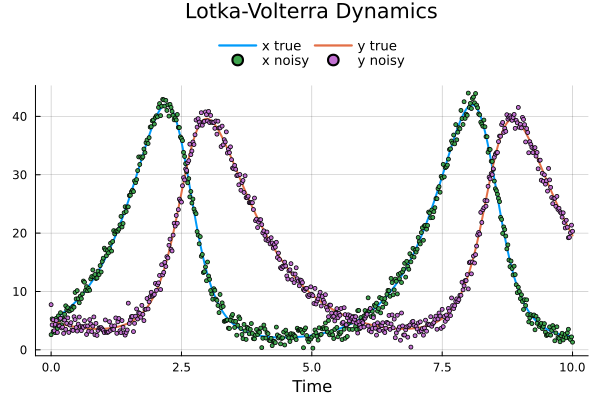

In [110]:
lv_orbits_2 = plot(sol.t, sol[1,:], lw=2, label="x true", grid=:true, gridalpha=0.3, legendfontsize=9, 
      legend=:outertop, legendcolumns=2, legendborder=false,legend_foreground_color=:transparent,
      title = "Lotka-Volterra Dynamics", fontsize =10) 
plot!(sol.t, sol[2,:], lw=2, label = "y true")
scatter!(sol.t, obs_noisy[1,:], ms=2.2, label= "x noisy")
scatter!(sol.t, obs_noisy[2,:], ms=2.2, label= "y noisy")
xlabel!("Time") 

In [ ]:
# savefig(lv_orbits_2, raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Plots\lv_orbits_2.png")

"C:\\Users\\mussi\\Documents\\Manhattan\\Leuven\\MCQMC\\Plots\\lv_orbits_2.png"

#### **Preliminary Analysis**

In [4]:
G = Tensor_Metric(lotka_volterra!, u0, log.([1.6, 0.1, 0.075, 1.0]), tspan, dt, sigma_eta)
G.FisherInfo

4×4 Symmetric{Float64, Matrix{Float64}}:
      4.67394e6  -55835.7        1.27959e6  2.33632e6
 -55835.7             4.80669e5  2.09183e5  2.19815e5
      1.27959e6       2.09183e5  7.51891e5  4.98712e5
      2.33632e6       2.19815e5  4.98712e5  1.68346e6

In [6]:
G.L

4×4 LowerTriangular{Float64, Matrix{Float64}}:
  0.00196375    ⋅             ⋅           ⋅ 
  0.00235579   0.00154744     ⋅           ⋅ 
 -0.00247131  -0.000368999   0.00128655   ⋅ 
 -0.0023008   -9.2741e-5    -0.00038113  0.000770723

In [10]:
CovScaling = 1; step_size = 0.01;
Prec   = (1 / (step_size^2 * CovScaling^2)) .* (G.FisherInfo)           
cholesky(Symmetric(Prec)).L  

4×4 LowerTriangular{Float64, Matrix{Float64}}:
     2.16193e5       ⋅         ⋅        ⋅ 
 -2582.68       69282.2        ⋅        ⋅ 
 59187.6        32399.3   54461.2       ⋅ 
     1.08066e5  35756.0  -47144.4  40684.2

In [133]:
# Normal priors on original parameter space
# priors = (Normal(0,1.0),   # alpha
#           Normal(0,1.0),   # beta
#           Normal(0,1.0),   # delta
#           Normal(0,1.0))   # gamma

# Gamma priors on original parameter space

priors = (
          Gamma(1, 1),   # alpha
          Gamma(1, 1),   # beta 
          Gamma(1, 1),   # delta
          Gamma(1, 1)    # gamma
)

# priors = (
#             truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5),
#             truncated(Normal(1.2, 0.5); lower=0, upper=2),
#             truncated(Normal(3.0, 0.5); lower=1, upper=4),
#             truncated(Normal(1.0, 0.5); lower=0, upper=2)
# )

# Lambda function: logprior_par(p)=logf​(α)+logf​(β)+logfδ(δ)+logf​(γ)
logprior_par = p -> (logpdf(priors[1], p[1]) + logpdf(priors[2], p[2]) + logpdf(priors[3], p[3]) + logpdf(priors[4], p[4]))

N_prop = 250 ; N_iter = 100
seq = rand(N_iter*(N_prop+1), 5)
a = [1.0, 0.2, 0.1, 1.3]
init_par = log.(a)

out_1 = IS_MP_sMALA_LV(lotka_volterra!, u0, obs_noisy, sigma_eta, tspan, dt, logprior_par,
                        init_par; seq=seq, N_prop=N_prop, N_iter=N_iter,step_size= 0.5, h_der=1e-3);

In [134]:
N_prop = 250 ; N_iter = 100
seq = rand(N_iter*(N_prop+1), 5)
a = [1.0, 0.2, 0.1, 1.3]
init_par = log.(a)
out_2 = IS_MP_MMALA_LV(lotka_volterra!, u0, obs_noisy, sigma_eta, tspan, dt, logprior_par,
                        init_par; seq=seq, N_prop=N_prop, N_iter=N_iter,step_size= 0.5, h_der=1e-3);

In [ ]:
# @save raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\Results\LV_mcqmc_SM.jld2" out_1
# @save raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\MCQMC_DS\Results\LV_mcqmc_MM.jld2" out_2

In [138]:
exp.(out_1.proposals[:,:, end])

251×4 Matrix{Float64}:
 1.50242  0.0997186  0.0749024  0.997797
 1.5044   0.0999761  0.0747169  0.995255
 1.50433  0.0999685  0.0748054  0.994796
 1.50067  0.0995446  0.0749697  0.998418
 1.50276  0.0998496  0.0747848  0.996665
 1.50471  0.0999808  0.0747745  0.994354
 1.50552  0.099998   0.0746018  0.994503
 1.50135  0.0998236  0.07496    0.997806
 1.50385  0.099946   0.0748191  0.995855
 1.50458  0.100039   0.0748394  0.994841
 ⋮                              
 1.50148  0.0997166  0.0748764  0.997334
 1.50586  0.100116   0.0746416  0.994074
 1.50597  0.100153   0.0746094  0.994435
 1.50324  0.100009   0.0747761  0.996153
 1.50424  0.100021   0.0746977  0.995282
 1.50243  0.0999164  0.0748949  0.996356
 1.50479  0.100092   0.0747574  0.994474
 1.50242  0.0999104  0.0748563  0.996419
 1.50253  0.0997726  0.0747953  0.996779

In [141]:
exp.(out_1.chain)

100×4 Matrix{Float64}:
 1.23686  0.185525   0.0790212  0.948942
 1.28545  0.158062   0.0818991  0.936555
 1.373    0.144379   0.0802573  0.906567
 1.41257  0.132193   0.0799393  0.923137
 1.44167  0.123442   0.0790677  0.93738
 1.45516  0.116819   0.0786643  0.953545
 1.46628  0.112109   0.0779172  0.965883
 1.47764  0.109237   0.0771161  0.972068
 1.485    0.106969   0.0765131  0.977708
 1.48839  0.105019   0.0761993  0.982957
 ⋮                              
 1.49791  0.0997931  0.0750752  1.00178
 1.49905  0.0997666  0.0750706  1.00135
 1.49978  0.0997271  0.0750645  1.00032
 1.50214  0.0998767  0.0749425  0.998229
 1.50028  0.0996747  0.0749815  1.00006
 1.50186  0.0996275  0.0749467  0.998709
 1.50139  0.0995647  0.0750414  0.998466
 1.50242  0.0997186  0.0749024  0.997797
 1.50324  0.100009   0.0747761  0.996153

In [8]:
out_1.weights

12×251 Matrix{Float64}:
 7.29394e-231  4.83327e-8    2.14192e-6    …  3.86847e-6    1.45504e-5
 1.40698e-134  0.000931917   8.52478e-6       2.16839e-5    2.59498e-8
 4.98228e-310  2.46601e-263  6.14547e-9       1.47304e-75   0.0
 3.26758e-64   0.000169273   1.96497e-5       0.00522286    6.15753e-8
 5.34226e-224  0.0           3.29359e-290     0.0           0.0
 1.0           0.0           0.0           …  0.0           0.0
 1.0           0.0           0.0              0.0           0.0
 1.0           0.0           0.0              1.13642e-315  0.0
 1.0           0.0           0.0              0.0           0.0
 1.0           0.0           0.0              0.0           0.0
 1.0           0.0           0.0           …  0.0           0.0
 1.0           0.0           0.0              0.0           0.0

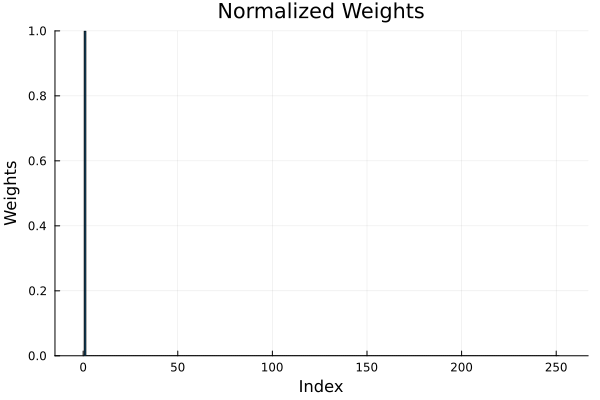

In [38]:
bar(out_1.weights[end,:], legend=false, xlabel="Index", ylabel="Weights", title="Normalized Weights", grid=true)

In [31]:
sum(out_1.weights[1,:])

1.0000000000000004

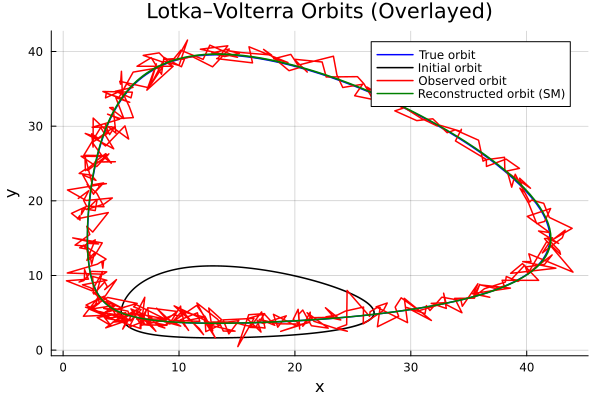

In [135]:
lok_volt_new = ODEProblem(lotka_volterra!, u0, tspan, exp.(out_1.chain)[end, :])
sol_new = solve(lok_volt_new, Tsit5(), saveat = dt)

lok_volt_new_mani = ODEProblem(lotka_volterra!, u0, tspan, exp.(out_2.chain)[end, :])
sol_new_mani = solve(lok_volt_new_mani, Tsit5(), saveat = dt)

lok_volt_initial = ODEProblem(lotka_volterra!, u0, tspan, a)
sol_initial = solve(lok_volt_initial, Tsit5(), saveat = dt)


gr()

p_overlay = plot(sol[1, :], sol[2, :],
    linewidth = 1.5, color = "blue", label = "True orbit",
    xlabel = "x", ylabel = "y",
    title = "Lotka–Volterra Orbits (Overlayed)",
    grid = true, gridalpha = 0.3, fontsize = 8)

plot!(p_overlay, sol_initial[1, :], sol_initial[2, :],
    linewidth = 1.5, color = "black", label = "Initial orbit")

plot!(p_overlay, obs_noisy[1, :], obs_noisy[2, :],
    linewidth = 1.5, color = "red", label = "Observed orbit")

plot!(p_overlay, sol_new[1, :], sol_new[2, :],
    linewidth = 1.5, color = "green", label = "Reconstructed orbit (SM)")

# plot!(p_overlay, sol_new_mani[1, :], sol_new_mani[2, :],
#     linewidth = 1.5, color = "orange", label = "Reconstructed orbit (M)")

display(p_overlay)

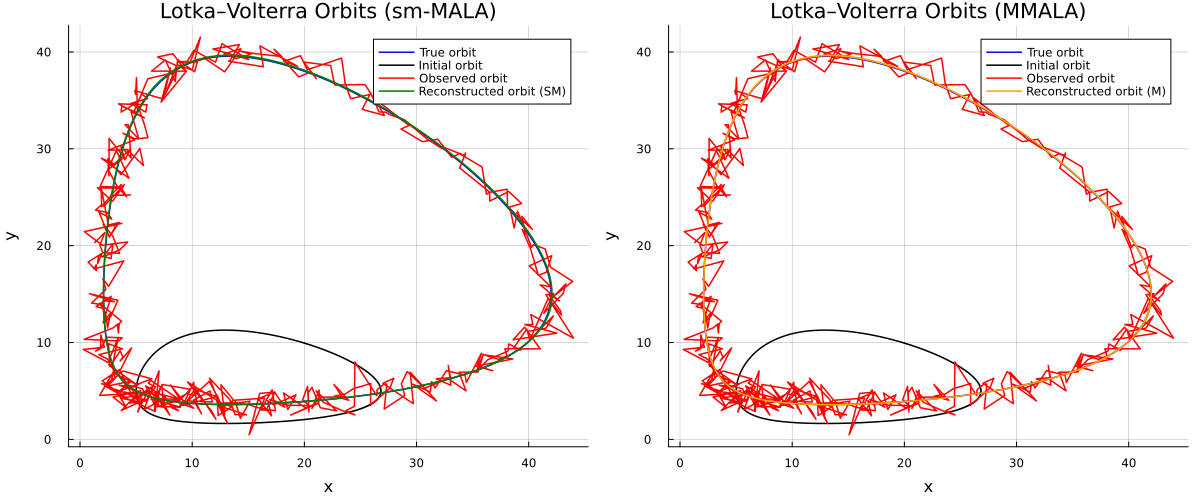

In [136]:
# ODE solves (as given)
lok_volt_new = ODEProblem(lotka_volterra!, u0, tspan, exp.(out_1.chain)[end, :])
sol_new = solve(lok_volt_new, Tsit5(), saveat = dt)

lok_volt_new_mani = ODEProblem(lotka_volterra!, u0, tspan, exp.(out_2.chain)[end, :])
sol_new_mani = solve(lok_volt_new_mani, Tsit5(), saveat = dt)

lok_volt_initial = ODEProblem(lotka_volterra!, u0, tspan, a)
sol_initial = solve(lok_volt_initial, Tsit5(), saveat = dt)

# Plotting
gr()

p_overlay_sm = plot(sol[1, :], sol[2, :],
    linewidth = 1.5, color = "blue", label = "True orbit",
    xlabel = "x", ylabel = "y",
    title = "Lotka–Volterra Orbits (sm-MALA)",
    grid = true, gridalpha = 0.3, fontsize = 8)

plot!(p_overlay_sm, sol_initial[1, :], sol_initial[2, :],
    linewidth = 1.5, color = "black", label = "Initial orbit")

plot!(p_overlay_sm, obs_noisy[1, :], obs_noisy[2, :],
    linewidth = 1.5, color = "red", label = "Observed orbit")

plot!(p_overlay_sm, sol_new[1, :], sol_new[2, :],
    linewidth = 1.5, color = "green", label = "Reconstructed orbit (SM)")

p_overlay_m = plot(sol[1, :], sol[2, :],
    linewidth = 1.5, color = "blue", label = "True orbit",
    xlabel = "x", ylabel = "y",
    title = "Lotka–Volterra Orbits (MMALA)",
    grid = true, gridalpha = 0.3, fontsize = 8)

plot!(p_overlay_m, sol_initial[1, :], sol_initial[2, :],
    linewidth = 1.5, color = "black", label = "Initial orbit")

plot!(p_overlay_m, obs_noisy[1, :], obs_noisy[2, :],
    linewidth = 1.5, color = "red", label = "Observed orbit")

plot!(p_overlay_m, sol_new_mani[1, :], sol_new_mani[2, :],
    linewidth = 1.5, color = "orange", label = "Reconstructed orbit (M)")

panel = plot(p_overlay_sm, p_overlay_m, layout = (1, 2), size = (1200, 500), bottom_margin = 5mm, left_margin = 5mm)
display(panel)


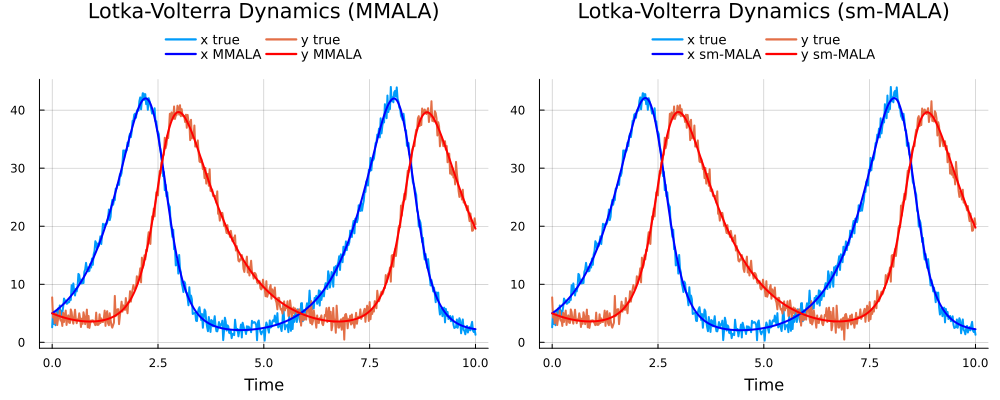

In [143]:
# Plot: MMALA
lv_orbits_mani = plot(sol.t, obs_noisy[1,:], lw=2, label="x true",
    grid=true, gridalpha=0.3, legendfontsize=9,
    legend=:outertop, legendcolumns=2, legendborder=false,
    legend_foreground_color=:transparent,
    title="Lotka-Volterra Dynamics (MMALA)", fontsize=10)
plot!(sol.t, obs_noisy[2,:], lw=2, label="y true")
plot!(sol.t, sol_new_mani[1,:], lw=2, ls=:solid, label="x MMALA", color=:blue)
plot!(sol.t, sol_new_mani[2,:], lw=2, ls=:solid, label="y MMALA", color=:red)
xlabel!("Time")

# Plot: sm-MALA
lv_orbits_sm = plot(sol.t, obs_noisy[1,:], lw=2, label="x true",
    grid=true, gridalpha=0.3, legendfontsize=9,
    legend=:outertop, legendcolumns=2, legendborder=false,
    legend_foreground_color=:transparent,
    title="Lotka-Volterra Dynamics (sm-MALA)", fontsize=10)
plot!(sol.t, obs_noisy[2,:], lw=2, label="y true")
plot!(sol.t, sol_new[1,:], lw=2, ls=:solid, label="x sm-MALA", color=:blue)
plot!(sol.t, sol_new[2,:], lw=2, ls=:solid, label="y sm-MALA", color=:red)
xlabel!("Time")

plot(lv_orbits_mani, lv_orbits_sm, layout=(1,2), size=(1000,400), bottom_margin=5mm)

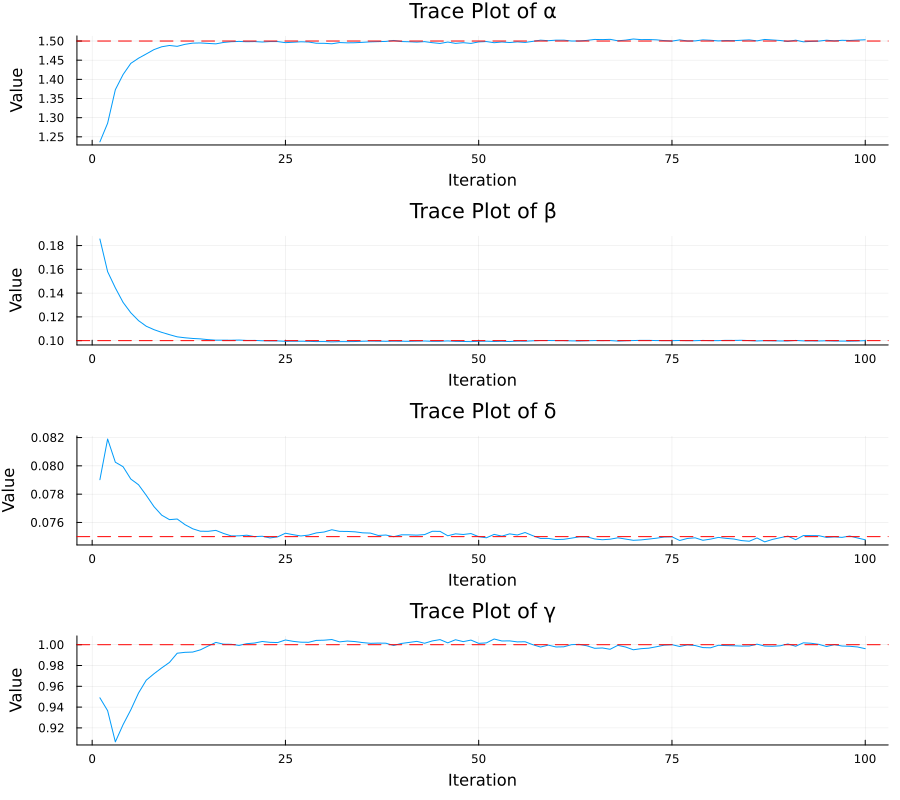

In [148]:
chain = exp.(out_1.chain)
iters = 1:size(chain, 1)

# Create trace plots
p1 = plot(iters, chain[:, 1], label="α", title="Trace Plot of α", xlabel="Iteration", ylabel="Value")
hline!(p1, [1.5], linestyle=:dash, color=:red)
p2 = plot(iters, chain[:, 2], label="β", title="Trace Plot of β", xlabel="Iteration", ylabel="Value")
hline!(p2, [0.1], linestyle=:dash, color=:red)
p3 = plot(iters, chain[:, 3], label="δ", title="Trace Plot of δ", xlabel="Iteration", ylabel="Value")
hline!(p3, [0.075], linestyle=:dash, color=:red)
p4 = plot(iters, chain[:, 4], label="γ", title="Trace Plot of γ", xlabel="Iteration", ylabel="Value")
hline!(p4, [1.0], linestyle=:dash, color=:red)

# Combine in a 4×1 layout
plot(p1, p2, p3, p4, layout=(4,1), size=(900,800), legend=false)

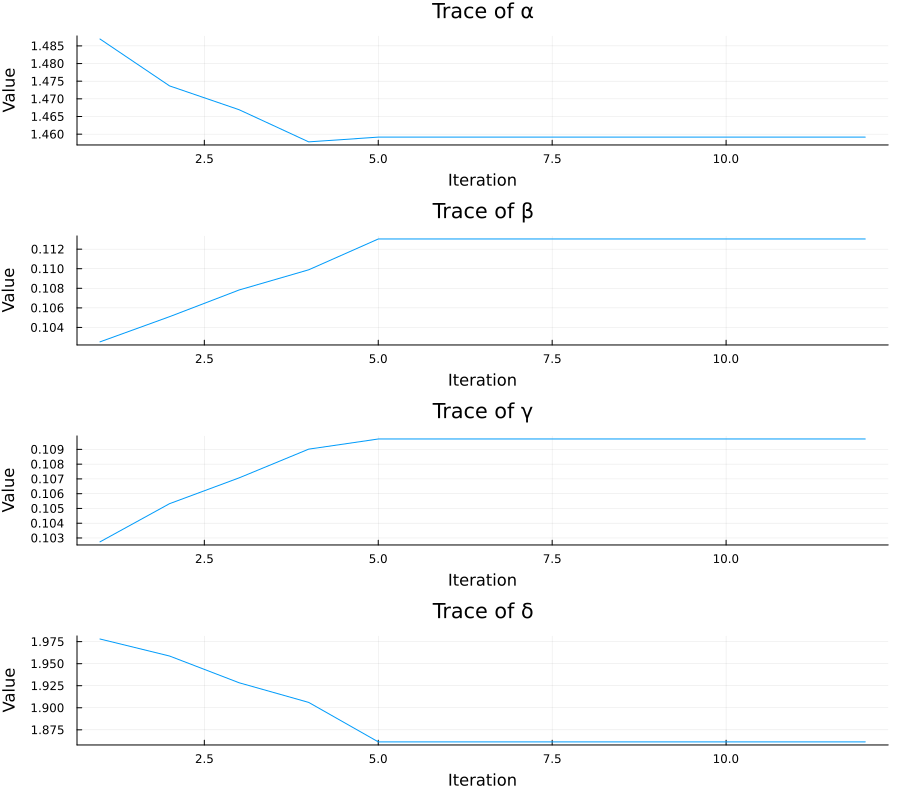

In [18]:
chain = out_1.chain

iters = 1:size(chain, 1)

p1 = plot(iters, exp.(chain[:, 1]), label="α", title="Trace of α", xlabel="Iteration", ylabel="Value")
p2 = plot(iters, exp.(chain[:, 2]), label="β", title="Trace of β", xlabel="Iteration", ylabel="Value")
p3 = plot(iters, exp.(chain[:, 3]), label="γ", title="Trace of γ", xlabel="Iteration", ylabel="Value")
p4 = plot(iters, exp.(chain[:, 4]), label="δ", title="Trace of δ", xlabel="Iteration", ylabel="Value")

# Combine in a 4×1 layout
plot(p1, p2, p3, p4, layout=(4,1), size=(900,800), legend=false)

#### **Lotka-Volterra smMALA**

In [5]:
priors = (
          Gamma(1, 1),   # alpha
          Gamma(1, 1),   # beta 
          Gamma(1, 1),   # delta
          Gamma(1, 1)    # gamma
)

# Lambda function: logprior_par(p)=logf​(α)+logf​(β)+logfδ(δ)+logf​(γ)
logprior_par = p -> (logpdf(priors[1], p[1]) + logpdf(priors[2], p[2]) + logpdf(priors[3], p[3]) + logpdf(priors[4], p[4]))

N_prop = 250 ; N_iter = 150
seq = rand(N_iter*(N_prop+1), 5)
a = [1.5, 0.1, 0.1, 2.0]
init_par = log.(a);


In [11]:
RiemMala = rmala_lv_single(
    lotka_volterra!, u0, obs_noisy, sigma_eta, tspan, dt, logprior_par, init_par;
    N_iter=10000,
    step_size=1.2,
    h_der=1e-3,
    cov_scaling=1.0,
    recompute_metric=true
);

In [10]:
exp.(RiemMala.chain_theta)

1000×4 Matrix{Float64}:
 1.40225  0.122583  0.123227  1.8213
 1.40225  0.122583  0.123227  1.8213
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 ⋮                            
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778
 1.54405  0.15024   0.109094  1.31778

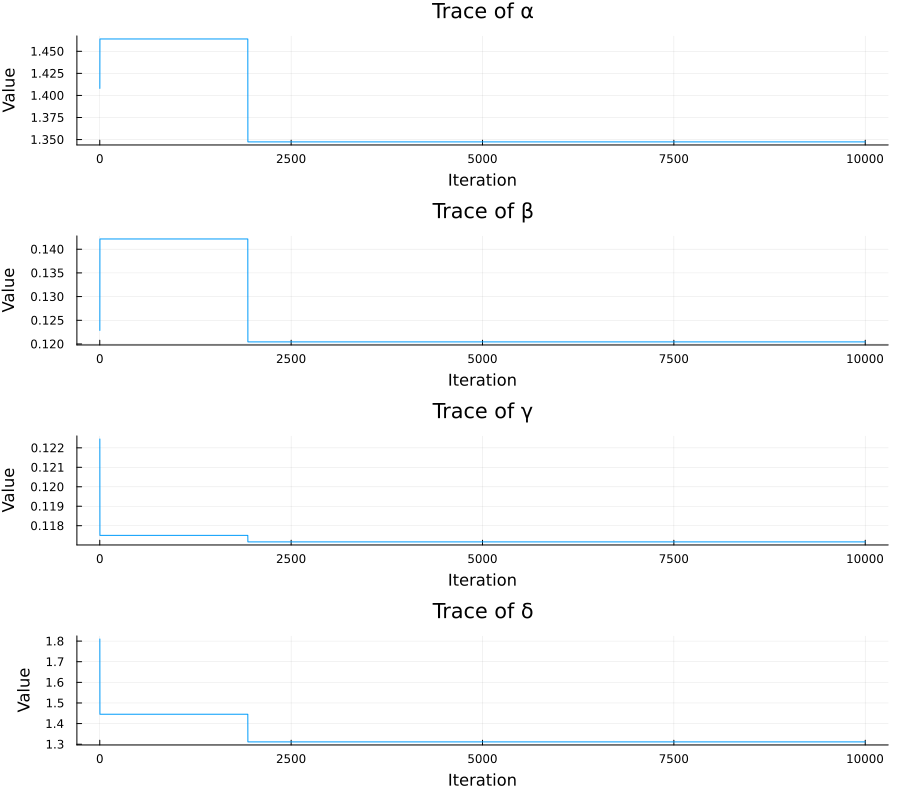

In [12]:
chain = (RiemMala.chain_theta)

iters = 1:size(chain, 1)

p1 = plot(iters, exp.(chain[:, 1]), label="α", title="Trace of α", xlabel="Iteration", ylabel="Value")
p2 = plot(iters, exp.(chain[:, 2]), label="β", title="Trace of β", xlabel="Iteration", ylabel="Value")
p3 = plot(iters, exp.(chain[:, 3]), label="γ", title="Trace of γ", xlabel="Iteration", ylabel="Value")
p4 = plot(iters, exp.(chain[:, 4]), label="δ", title="Trace of δ", xlabel="Iteration", ylabel="Value")

# Combine in a 4×1 layout
plot(p1, p2, p3, p4, layout=(4,1), size=(900,800), legend=false)

### **Lorenz System**

In [2]:
sigma = 10.0
rho = 28.0
beta = 8/3

# Lorenz system
function lorenz!(du, u, p, t)
    x, y, z = u
    du[1] = sigma * (y - x)
    du[2] = x * (rho - z) - y
    du[3] = x*y - beta*z
end

tspan = (0.0, 1.0)
u0 = [1.0, 1.0, 1.0];

prob = ODEProblem(lorenz!, u0, tspan);
step = 0.1; sol = solve(prob, Tsit5(), saveat=step);                   # Float64 Matrix
sigma_eta = 0.1 * I(3)              
dist = MvNormal(zeros(3), sigma_eta)   
                                  
obs_noisy = Array(sol) .+ rand(dist, size(sol, 2)); 

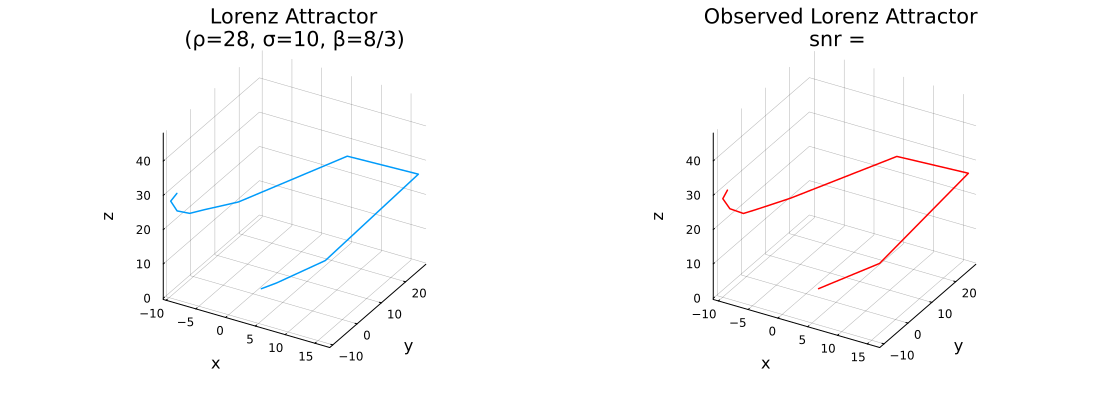

In [ ]:
gr()

p1 = plot(sol[1,:], sol[2,:], sol[3,:], linewidth = 1.5, 
           title = "Lorenz Attractor\n" * "(ρ=28, σ=10, β=8/3)", 
           xlabel = "x", ylabel = "y", zlabel = "z", 
           legend = false, grid = true, gridalpha = 0.3 )

p2 = plot(obs_noisy[1,:], obs_noisy[2,:], obs_noisy[3,:], linewidth = 1.5,
    title = "Observed Lorenz Attractor \n" * "snr =  ",
    xlabel = "x", ylabel = "y", zlabel = "z",
    legend = false, color = "red", grid = true, gridalpha = 0.3)

plot( p1, p2, layout = (1, 2), size = (1100, 400))

In [4]:
# Known Σ 
Σ = Matrix(sigma_eta)         

# Prior
μ0 = obs_noisy[:, 1]
prior_std_x0 = 0.1
prior_x0 = MvNormal(μ0, Diagonal(fill(prior_std_x0^2, 3)))

# Log-density of the prior 
logprior_x0 = x0 -> logpdf(prior_x0, x0)                    # Lambda function

# Sample initial state from the prior
rng = MersenneTwister(1234); x0_init = rand(rng, prior_x0)

3-element Vector{Float64}:
 1.489799356521385
 1.5613259838869409
 1.102359432567175

In [6]:
# QMC/CUD uniforms: ((N+1)L)×4
N_prop = 3; N_iter = 30
wcud = rand(N_iter*(N_prop+1), 4)  # replace with your CUD/QMC block

out = MP_IS_MALA(
                    lorenz!, 
                    x0_init;
                    obs = obs_noisy,
                    cov_mat   = Σ,
                    tspan = tspan,
                    dt    = step,          
                    seq = wcud,
                    N_prop = N_prop,
                    N_iter = N_iter,
                    step_size = 0.005,
                    logprior_x0 = logprior_x0,
                    h_der = 1e-6)

chains = out.chain_x0

UndefVarError: UndefVarError: `acc_proxy` not defined in local scope
Suggestion: check for an assignment to a local variable that shadows a global of the same name.

In [ ]:
out.grad

In [ ]:
out.proposals

In [ ]:
out.weighted_mean

In [ ]:
# --- raccogli le 4 catene ---
A = [results[i].chain_theta[burn_in:end, :] for i in 1:4]   # ciascuna (N, d)
N, d = size(A[1])
@assert all(size(A[i]) == (N, d) for i in 1:4)

# --- array 3D nella forma (iter, param, chain) attesa da MCMCChains ---
arr = Array{Float64}(undef, N, d, 4)
for c in 1:4
    arr[:, :, c] = A[c]
end

pnames = Symbol.("θ", 1:d)
chn = Chains(arr, pnames)  

describe(chn)